# <center>Curso de Modelagem de Dados para IA - PARTE 15</center>

<img src="img/image.jpg" alt="Drawing" style="width: 300px;"/>


## Uma Breve História Visual de Rebatidas no Beisebol
A visualização é uma maneira útil de resumir conjuntos de dados complexos. Podemos usar várias ferramentas de visualização, por exemplo, para resumir toda a história de rebatidas no beisebol. Para isso, faremos uso do pacote <span style="font-family: 'Courier'">seaborn</span> (convencionalmente importado como sns).

Estamos especificamente interessados aqui não apenas nos quatro tipos de rebatidas, mas também em alguns outros resultados importantes de rebatidas: strikeouts (SO) e bases-on-balls (BB), também conhecidos como walks, bem como corridas marcadas (R) e corridas impulsionadas (RBI). Assim, restringiremos nossa atenção ao seguinte conjunto de variáveis no dataframe de rebatidas: <span style="font-family: 'Courier'">hit_vars = ('1B', '2B', '3B', 'HR', 'SO', 'BB', 'R', 'RBI ')</span>.

O dataframe <span style="font-family: 'Courier'">batting_by_year</span> que criamos na parte sobre operações <span style="font-family: 'Courier'">groupby</span> é útil para algumas análises, mas também é confuso pelo fato de o beisebol da MLB ter crescido ao longo do tempo, tanto em termos de número de times na liga quanto em número de jogos disputados em uma temporada. Assim, os totais por ano cresceram ao longo do tempo, em parte devido ao simples fato de que o número total de jogos disputados e rebatidas por temporada aumentou. Abaixo, criaremos um novo dataframe que leva em conta esse efeito, calculando as estatísticas de rebatidas por at-bat (AB).

Um *PairGrid* é usado para traçar a relação entre todos os pares de variáveis de interesse (por exemplo, <span style="font-family: 'Courier'">hit_vars</span>), com os quais podemos sobrepor informações de cores adicionais para apresentar um histórico sucinto de rebatidas no beisebol. O <span style="font-family: 'Courier'">Seaborn</span> (sns) fornece uma função de conveniência chamada <span style="font-family: 'Courier'">pairplot</span> que gera um gráfico de pares, com gráficos de dispersão entre variáveis nas células da grade fora da diagonal e histogramas de cada variável ao longo da diagonal. Ao colorir esses gráficos com informações de tempo, podemos ver a história das rebatidas no beisebol à medida que se desenrola ao longo das décadas. Para ver melhor a progressão do tempo nesta visualização, é útil agrupar os dados ano a ano em décadas, o que pode ser feito adicionando uma nova coluna ao dataframe (<span style="font-family: 'Courier'">decade</span>) que faz o cálculo usando <span style="font-family: 'Courier'">np.floor_divide</span> em cada linha. O tempo progride de azul claro para azul escuro nesses gráficos.

In [1]:
import pandas as pd
import numpy  as np
import seaborn as sns
import matplotlib.pyplot as plt
import glob
import os

In [2]:
def read_all_databank_core_csv(directory):
    """
    read all csv files in the specified baseball databank directory and
    populate a dictionary storing each of the tables keyed to its name
    """
    dfs = {}
    files = glob.glob('{}/*.csv'.format(directory))
    for f in files:
        d, name = os.path.split(f)
        table = os.path.splitext(name)[0]
        df = pd.read_csv(f)
        dfs[table] = df
    return dfs

bbdfs = read_all_databank_core_csv('data/baseballdatabank/core')

# let's extract a few for further processing
batting = bbdfs['Batting']
pitching = bbdfs['Pitching']
teams = bbdfs['Teams']
batting['1B'] = batting['H'] - batting['2B'] - batting['3B'] - batting['HR']
teams['1B'] = teams['H'] - teams['2B'] - teams['3B'] - teams['HR']
batting_by_year = batting.groupby('yearID').sum().reset_index()

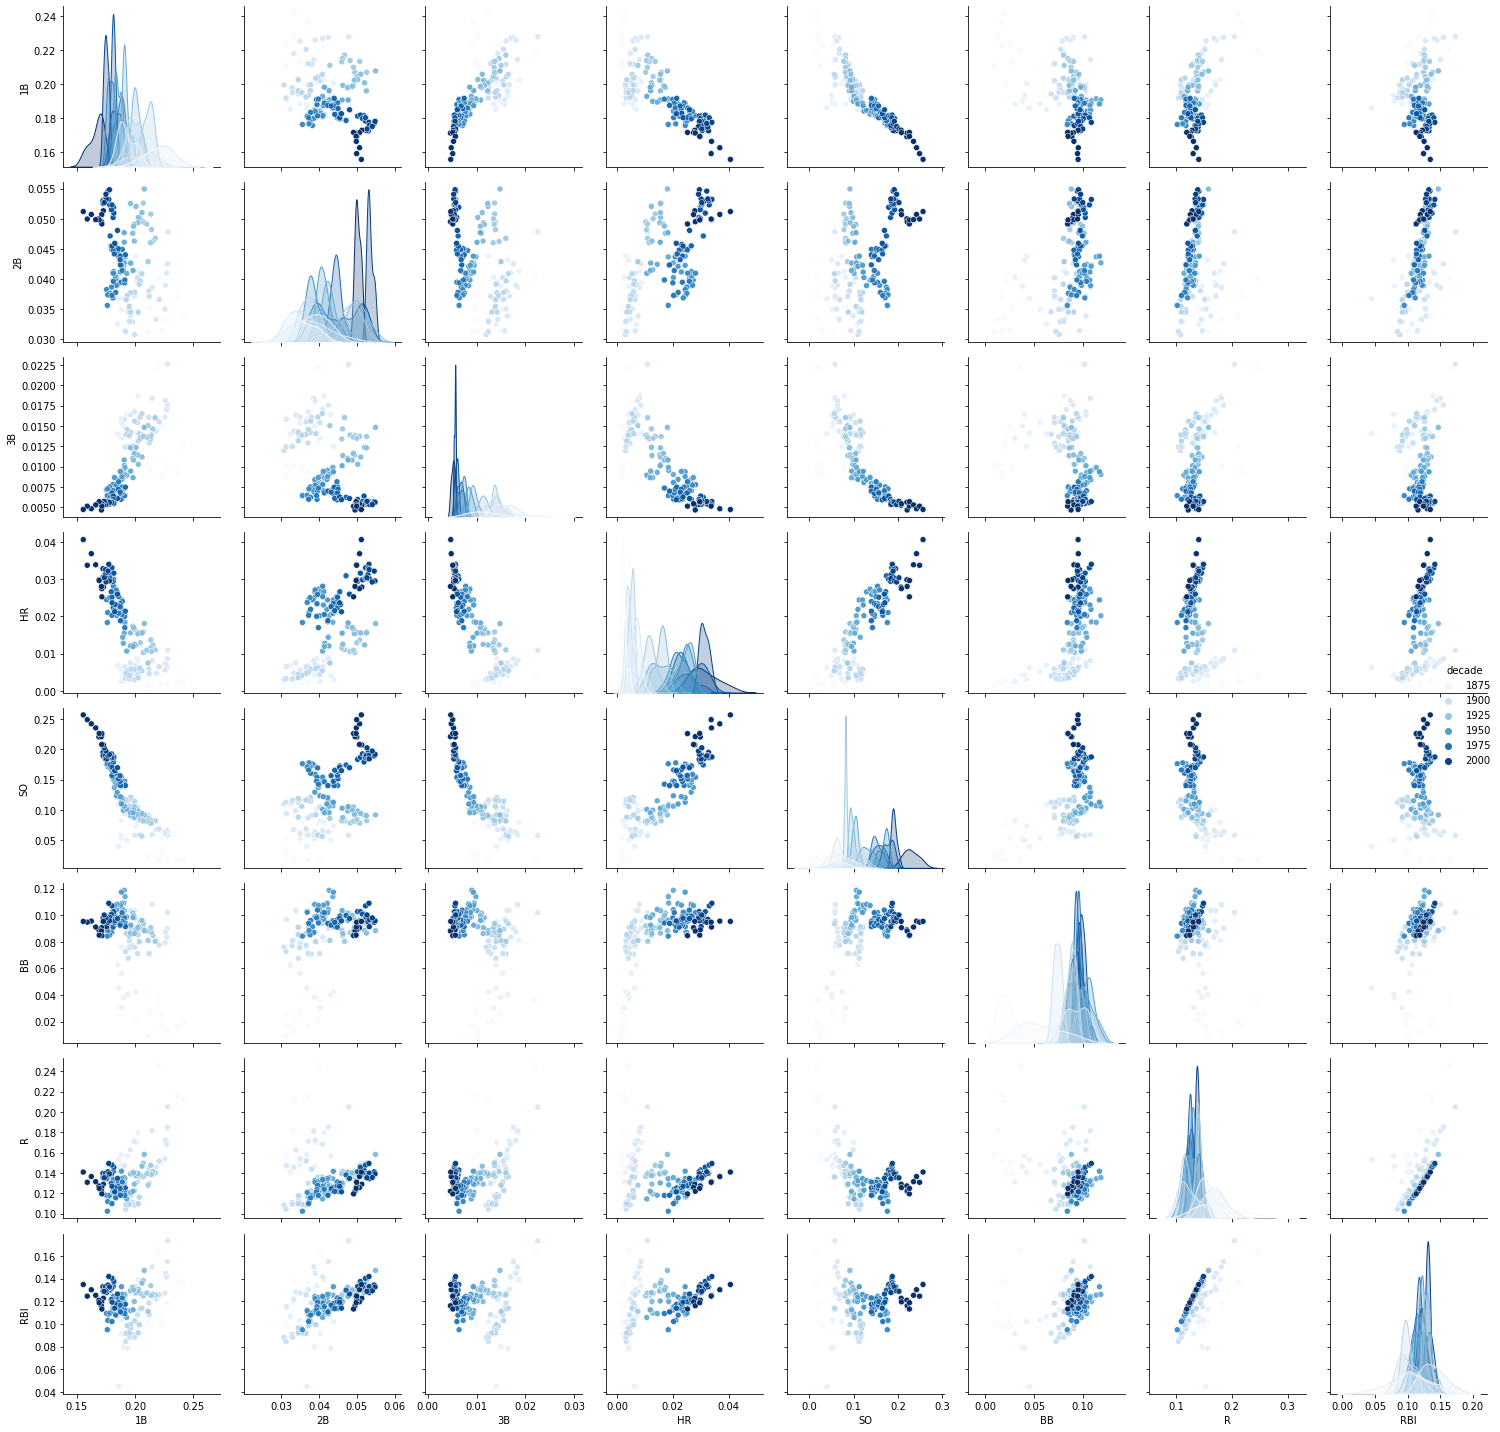

In [3]:
# create new dataframe that computes per-at-bat averages for each batting category
batting_per_AB_by_year = batting_by_year.copy()
for col in batting_per_AB_by_year.columns:
    if col in ['yearID', 'stint', 'G', 'AB']:
        continue
    batting_per_AB_by_year[col] = batting_per_AB_by_year[col]/batting_per_AB_by_year['AB']

batting_per_AB_by_year['decade'] = np.floor_divide(batting_per_AB_by_year['yearID'],10)*10

hit_vars = ('1B', '2B', '3B', 'HR', 'SO', 'BB', 'R', 'RBI')

pg = sns.pairplot(batting_per_AB_by_year, vars=hit_vars, hue='decade', palette='Blues')
plt.tight_layout()
plt.savefig("batting_scatterplot_matrix_seaborn_pairgrid.png")

Há uma rica história a ser descoberta aqui. Ao longo das diagonais, podemos ter uma noção de como os diferentes resultados de rebatidas mudaram ao longo do tempo (de claro para escuro): rebatidas 1B e 3B diminuíram, home runs (HR) e strikeouts (SO) geralmente aumentaram, e rebatidas 2B aumentaram um caminho de altos e baixos ao longo do tempo. Talvez o par de resultados mais fortemente correlacionado envolva HR e SO, que a maioria das pessoas que acompanham o beisebol da MLB certamente reconhecerá.

Podemos resumir as correlações entre pares dentre os resultados de acerto incorporados nos dados do gráfico de dispersão acima usando o método <span style="font-family: 'Courier'">corr()</span> no subconjunto <span style="font-family: 'Courier'">hit_vars</span> do dataframe e, em seguida, exibindo todos os valores de correlação com um mapa de calor. Isso, de fato, confirma nossa percepção de que a correlação HR-SO é a mais forte entre todas as variáveis de acerto.

<AxesSubplot:>

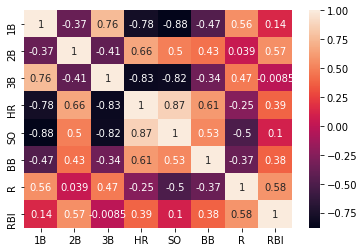

In [4]:
sns.heatmap(batting_per_AB_by_year[list(hit_vars)].corr(), annot=True)

### Saga dos Home Runs
Para muitos fãs de beisebol, a parte mais emocionante do esporte é o *home run*. A partir do gráfico de dispersão anterior, vimos que a taxa de *home runs* aumentou constantemente ao longo do tempo. Podemos examinar isso com um pouco mais de detalhes traçando a taxa de HR por AB ao longo do tempo, usando o método de plotagem no dataframe <span style="font-family: 'Courier'">batting_per_AB_by_year</span>. O bloco de código abaixo também inclui algumas anotações relevantes para a história de *home runs* no beisebol, adicionadas usando a função <span style="font-family: 'Courier'">plt.text</span> do matplotlib.

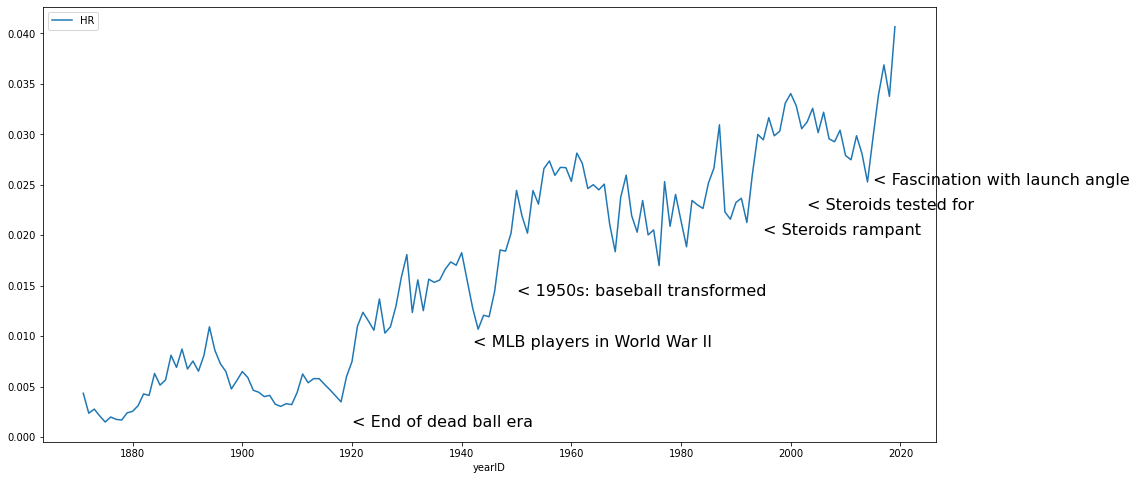

In [5]:
ax = batting_per_AB_by_year.plot('yearID', 'HR', figsize=(16,8))
annot1920 = plt.text(1920, 0.001, '< End of dead ball era', fontsize=16)
annot1942 = plt.text(1942, 0.009, '< MLB players in World War II', fontsize=16)
annot1950 = plt.text(1950, 0.014, '< 1950s: baseball transformed', fontsize=16)
annot1995 = plt.text(1995, 0.020, '< Steroids rampant', fontsize=16)
annot2003 = plt.text(2003, 0.0225, '< Steroids tested for', fontsize=16)
annot2015 = plt.text(2015, 0.025, '< Fascination with launch angle', fontsize=16)